# Evaluating Missing-Value Strategies for ID3 on Small vs. Large Data

## Abstract

Missing value are a significant challenge in real world machine learning, directly impacting the model perform.
This activities studies how different strategies for handling with missing values affect the performance on a ID3 decision tree. I have done the same workflow on two dataset with very different size, comparing different strategy for handle with missing values. result show that no single strategy is the best everywhere.
Overall, the experiments highlight that the choice of imputation method clearly matters, and that dataset size and evaluation goal must both be considered when deciding how to handle missing values.

---
## Overview

The goal is understand how different strateghy for handling missing value change the quality of the model, training the same ID3 model with the same split introducing as well missing value totaly at random.

---
## Missing Value Handling Strategy

- Row Deletion
- Replacing with most frequent for column
- Replace with most frequent value within each class
- Mean imputation
- Median imputation
- k-NN Imputation

---
## Dataset

- Titanic: small dataset with binary classification for survival *~890 rows*
- Adult Income: larger dataset with binary classification for income >50K *~48k rows*



In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import f1_score
income_train_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
income_test_url  = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test"


In [2]:
# Datasets
# ---- Titanic ----
# Load seaborn titanic dataset
titanic_row = sns.load_dataset('titanic').copy()
# taget survived
target_name = 'survived'
base_features = ['sex','pclass','age','fare','sibsp','parch','embarked','deck']

# split feature and labels
features_titanic = titanic_row[base_features].copy()
labels_titanic = titanic_row[target_name].copy()

# sex -> 0/1
mask_not_null = features_titanic["sex"].notna()
features_titanic.loc[~mask_not_null, "sex"] = np.nan  # Keep NaN
features_titanic.loc[mask_not_null, "sex"] = np.where(
    features_titanic.loc[mask_not_null, "sex"] == "female", 1, 0
)
# embarked -> S=0 C=1 Q=2
mask_not_null = features_titanic["embarked"].notna()
cond = [
    features_titanic["embarked"].eq("S") & mask_not_null,
    features_titanic["embarked"].eq("C") & mask_not_null,
    features_titanic["embarked"].eq("Q") & mask_not_null,
]
choices = [0, 1, 2]
features_titanic["embarked"] = np.select(cond, choices, default=np.nan)

# deck -> 1 .. 8
mask_not_null = features_titanic["deck"].notna()
cond = [features_titanic["deck"].eq(x) & mask_not_null for x in list("ABCDEFG")] + \
       [features_titanic["deck"].eq("T") & mask_not_null]
choices = [1, 2, 3, 4, 5, 6, 7, 8]
features_titanic["deck"] = np.select(cond, choices, default=np.nan)

features_titanic = features_titanic.astype(float)


print(features_titanic.head())
print(features_titanic.columns)
print(features_titanic.shape, labels_titanic.shape)

print("---------------------------")

#----Adult Income----
cols = [
    "age","workclass","fnlwgt","education_num","marital_status",
    "occupation","relationship","race","sex","capital_gain","capital_loss",
    "hours_per_week","native_country","income"

]
target_name = "income"

adult_train = pd.read_csv(
    income_train_url, names=cols, skipinitialspace=True
)
adult_test = pd.read_csv(
    income_test_url, names=cols, skipinitialspace=True, skiprows=1
)

# merge two part
adult = pd.concat([adult_train, adult_test], ignore_index=True)
adult1 = adult.copy()

# clean label
adult[target_name] = adult[target_name].astype(str).str.replace(".", "", regex=False).str.strip()
bolean_label = {">50K": 1, "<=50K": 0}
adult["income"] = adult["income"].map(bolean_label).astype("Int8")
adult = adult.replace("?", np.nan)

# sex -> 0/1
adult["sex"] = adult["sex"].map({"Male":0, "Female":1}).astype("float")

# Age column wrong in the dataset dosent indicate the age
adult.rename(columns={"age": "employment_status"}, inplace=True)
def encode_col(df, col):
    cats = sorted(df[col].dropna().unique().tolist())
    mp = {k:i for i,k in enumerate(cats)}
    return df[col].map(mp).astype("float")

for col in ["employment_status","workclass","marital_status","occupation","fnlwgt",
            "relationship","race","native_country"]:
    adult[col] = encode_col(adult, col)

# final feature / label split
features_adult = adult.drop(columns=[target_name]).copy()
features_adult = features_adult.astype(float)

labels_adult   = adult[target_name].copy()


print(features_adult.head())
print(features_adult.columns)
print(features_adult.shape, labels_adult.shape)


   sex  pclass   age     fare  sibsp  parch  embarked  deck
0  0.0     3.0  22.0   7.2500    1.0    0.0       0.0   NaN
1  1.0     1.0  38.0  71.2833    1.0    0.0       1.0   3.0
2  1.0     3.0  26.0   7.9250    0.0    0.0       0.0   NaN
3  1.0     1.0  35.0  53.1000    1.0    0.0       0.0   3.0
4  0.0     3.0  35.0   8.0500    0.0    0.0       0.0   NaN
Index(['sex', 'pclass', 'age', 'fare', 'sibsp', 'parch', 'embarked', 'deck'], dtype='object')
(891, 8) (891,)
---------------------------
   employment_status  workclass  fnlwgt  education_num  marital_status  \
0                6.0     3461.0     9.0           13.0             4.0   
1                5.0     3788.0     9.0           13.0             2.0   
2                3.0    18342.0    11.0            9.0             0.0   
3                3.0    19995.0     1.0            7.0             2.0   
4                3.0    25405.0     9.0           13.0             2.0   

   occupation  relationship  race  sex  capital_gain  cap

# Implementation of ID3 Algorithm


The ID3 (Iterative Dichotomiser3) Algorithm is a greedy algorithm that build a decision tree by recursively partitioning the data into a smaller and smaller subsets untill data points in each subset belong to the same class. This decision tree is used for both classification and regression tasks.

This algo utilize metrics related to information theroy particularly entropy and information gain, to make decisions during the tree-building process.

**Information Gain and Attribute Selection**
The ID3 use a measure of impurity to calculate the iformation gain of each atribute. Entropy is a measure of disorder in a dataset, so a dataset with high entropy is a dataset where the data points are evenly distributed across the diferent category, conversely a dataset with low entropy is a dataset where the data points are concatenated in one or few categories.

**Calculating the entropy**
\begin{equation}
E(S) = - \sum_{i=1}^{C} P_i \log_2(P_i)
\end{equation}
- $C$ number of classes
- $ P_i $ fracton of the sample within a particular node.
- $ S $ is the current dataset
- $ i $ is set of classes in $ S $

**Information Gain**
\begin{equation}
IG(A, S) = E(S) - \sum_{v} \frac{|S_v|}{|S|} E(S_v)
\end{equation}
- $|S|$ is the total number of istances in dataset
- $|S_v|$ is the number of istances in dataset for which attribute D has value $v$
- $H(S)$ is the entropy of the dataset

Then we select the feature with the higest information gain and iterativly we apply all the steps above for building the decision tree

Theory of the ID3 seen in class and also [geeksforgeeks](https://www.geeksforgeeks.org/machine-learning/sklearn-iterative-dichotomiser-3-id3-algorithms/)

In [3]:
# ENTROPY CALCULATION
def entropy(y):   # y: labels
  total_row = len(y)
  unique_labels, counts = np.unique(y, return_counts=True) # unique labels and their counts
  P = counts / total_row # Computing probability
  return -np.sum(P * np.log2(P)) # entropy formula

# INFORMATION GAIN CALCULATION
def information_gain(X_col, y):   # X_col: feature column, y: labels
  gain = entropy(y)
  unique_val = np.unique(X_col)
  # for each unique value on X_col calculate the wighted entropy
  for value in unique_val:
    y_split = y[X_col == value]
    gain -= (len(y_split) / len(y)) * entropy(y_split)
  return gain

# ID3 DECISION TREE ALGORITHM (RECOURSIVE)
def id3(X, y, depth = 0, max_depth = None):   # X: feature, y: labels, depth: current depth, max_depth: maximum depth of tree
  # all labels are the same
  if len(np.unique(y)) == 1:
    return y[0]

  # no feature left or max depth reached
  if X.empty or (max_depth is not None and depth >= max_depth):
    return np.bincount(y).argmax()

  # calculation gain for all the features
  gains = [information_gain(X[col], y) for col in X.columns]
  # select the feature with best information gain
  best_feature = X.columns[np.argmax(gains)]
  # create tree node
  tree = {best_feature: {}}
  # split on each unique value of the best feature
  for value in np.unique(X[best_feature]):
    data_sub = X[X[best_feature] == value]
    label_sub = y[X[best_feature] == value]
    # recoursive call, build the subtree
    tree[best_feature][value] = id3(
        data_sub.drop(columns=[best_feature]), # feature already used
        label_sub,
        depth+1,
        max_depth
      )
  return tree

def fit_id3(X_train: pd.DataFrame, y_train, max_depth=None):
  # encode labels
  y_arr = np.asarray(y_train)
  classes, y_enc = np.unique(y_arr, return_inverse=True)
  # keep majority class index
  majority = int(np.bincount(y_enc).argmax())
  # build tree on encode labels
  tree = id3(X_train, y_enc, depth=0, max_depth=max_depth)
  return{
      "tree": tree,
      "classes": classes,
      "majority": majority
  }

def predict_id3(model, X_test: pd.DataFrame):
  # unpack label mapping
  classes = model["classes"]
  majority_idx = model["majority"]
  majority_label = classes[majority_idx]

  predictions = []
  # walk each row
  for _,x in X_test.iterrows():
    subtree = model["tree"]
    predicted = None
    # follow feature -> value branches untill leaf
    while isinstance(subtree, dict):
      feat = next(iter(subtree))
      val = x.get(feat, np.nan)
      if pd.isna(val):
        # missing -> fall to majority class
        predicted = majority_label
        break
      branch = subtree[feat].get(val, None) # go to child
      if branch is None:
        predicted = majority_label
        break
      # keep going down the tree
      subtree = branch
    # we are in the leaf
    if predicted is None:
      predicted = classes[int(subtree)]
    # collect predictions
    predictions.append(predicted)

  return np.array(predictions)

## Introducing artificially missing value in the datasets

Artificially inject NaNs at fixed rate (15%) and also return a boolean mask for mark the artificial NaNs. I do this for evaluate the different strategy in the imputation accuracy.
In this code the strategy for injecting the missing value is **MCAR** (Missing Completely At Random), maby different strategy like MAR oe MNAR could change the evaluation.


In [4]:
# Introduce artifically missing
def artificial_missing(dataset, cols=None, missing_rate = 0.15, random_state=42):
  # rng for reproducibility
  random = np.random.default_rng(random_state)
  dataset_missing = dataset.copy()

  if cols is None:
    cols = dataset.columns.tolist() # if not specified applied to all columns
  # all mask false
  mask = pd.DataFrame(False, index=dataset.index, columns=dataset.columns)
  for c in cols:
    # consider only cell that are not NaN
    not_NaN_idx = dataset[c].notna().values
    n = not_NaN_idx.sum() # how many valid cell in column
    k = int(np.round(missing_rate * n)) # how many to blank
    if k == 0:
      continue
    inject_positions = np.where(not_NaN_idx)[0]
    chosen = random.choice(inject_positions, size=k, replace=False)
    # set the cell to NaN
    dataset_missing.loc[dataset.index[chosen], c] = np.nan
    # put in the mask df True where we artificially NaN the value
    mask.loc[dataset.index[chosen], c] = True

  return dataset_missing, mask

## Missing Value Handling Strategies

Now we implement the six strategy for handling with missing value, the idea is use this function before call the ID3 so we can see the impact of each method.

In [78]:
# Del the row
def delete_row(dataset):
  # Drop row that contains at least one NaN
  ds_clean = dataset.copy()
  ds_clean = ds_clean.dropna()
  return ds_clean

# Replacing with most frequent
def most_frequent(dataset):
  # Fill each NaN with the column most frequent
  X = dataset.copy()
  for col in X.columns:
    if X[col].isnull().any():
      most_frequent = X[col].mode()[0]
      X.fillna({col: most_frequent}, inplace=True)  # Only in the current col
  return X

# Replacing with the most frequent within each class
def most_frequent_by_class(dataset, feature):
  X = dataset.copy()
  y = feature.copy()
  y_class = y.unique()

  for col in X.columns:
    missing_bool = X[col].isnull()
    for class_val in y_class:
      mask = missing_bool & (y == class_val)
      if mask.any():
        most_frequent = X.loc[y == class_val, col].mode()[0]
        X.loc[mask, col] = most_frequent
  return X

# Replacing missing value with mean
def mean_method(dataset):
  X = dataset.copy()
  for col in X.columns:
    X[col] = X[col].fillna(X[col].mean())
  X = X.round()
  return X

# Replacing missing value with median
def median_method(dataset):
  X = dataset.copy()
  for col in X.columns:
    X[col] = X[col].fillna(X[col].median())
  return X

# Predicting the missig value with Knn
def knn_method(dataset):
  X = dataset.copy()
  imputer = KNNImputer(n_neighbors=3, weights='distance')
  after_imputation = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)
  return after_imputation




## Build Imputed Versions and Measure Imputation Accuracy

This block inject the artificial missing value, run the six imputation strategy saving the imputed ds and the results


In [79]:
# function for introducing the missing and call the methods, return dict with the dataset and the results
def impute_after_split(X_train, y_train, X_test):
  train_idx = X_train.index
  test_idx = X_test.index

  # dicts to store results per methods
  result_summary = {}
  imputed = {}

  # train + test
  X = pd.concat([X_train, X_test], axis = 0)

  # inject artificial missing + mask for evaluate
  X_miss , mask = artificial_missing(X)

  # Dropping row method
  X_train_miss, mask_train = artificial_missing(X_train)
  X_test_miss, mask_test = artificial_missing(X_test)

  X_train_drop = delete_row(X_train_miss)
  X_test_drop = delete_row(X_test_miss)
  row = len(X_train_drop) + len(X_test_drop)
  # num of rows survived
  imputed["Drop_Row"] = {
      "X_train": X_train_drop,
      "X_test": X_test_drop,
    }
  result_summary["Drop_Row"] = {
      "cells": int(mask_train.values.sum() + mask_test.values.sum()), # number of cells blanked
      "correct": 0, # for definition of this method there is not correct imputation
      "accuracy": 0.0,
      "remaning_row": float(row),
  }



  # Most frequent
  X_freq = most_frequent(X_miss.copy())
  row = len(X_freq) # equal to original, no rows removed
  imputed["Most_Frequent"] = {
      "X_train": X_freq.loc[train_idx],
      "X_test":  X_freq.loc[test_idx],
  }
  correct = ((X_freq == X) & mask).values.sum() # comapare only where mask == true
  cells = int(mask.values.sum())
  result_summary["Most_Frequent"] = {
      "cells": cells,
      "correct": int(correct),
      "accuracy": float(correct / cells if cells else float("NaN")),
      "remaning_row": float(row),
  }

  # Most_Frequent_with_Class
  X_tr_ca = X_miss.loc[train_idx].copy()
  mask_tr  = mask.loc[train_idx]  # mask only on the train
  # in this method we cant compute the NaNs on the test part, becouse we don't know the labels for the row

  # computing the call on the column
  for col in X_tr_ca.columns:
      miss = X_tr_ca[col].isna()
      for cls in np.unique(y_train):
          m = X_tr_ca.loc[y_train == cls, col].mode(dropna=True)
          if not m.empty:
              X_tr_ca.loc[miss & (y_train == cls), col] = m.iloc[0]

  fallback = X_miss.loc[train_idx].mode(dropna=True).iloc[0]
  X_tr_ca = X_tr_ca.fillna(fallback)
  X_te_ca = X_miss.loc[test_idx].fillna(fallback)
  # storing imputate splits
  imputed["Most_Frequent_with_Class"] = {
      "X_train": X_tr_ca,
      "X_test":  X_te_ca,
  }
  # storing the stats
  cells   = int(mask_tr.values.sum())
  row = len(X_tr_ca)
  correct = ((X_tr_ca == X.loc[train_idx]) & mask_tr).values.sum()
  result_summary["Most_Frequent_with_Class"] = {
      "cells": cells,
      "correct": int(correct),
      "accuracy": float(correct / cells if cells else float("NaN")),
      "remaning_row": float(row),
  }

  # Mean
  X_mean = mean_method(X_miss.copy())
  row = len(X_mean)
  imputed["Mean"] = {
      "X_train": X_mean.loc[train_idx],
      "X_test":  X_mean.loc[test_idx],
  }
  correct = ((X_mean == X) & mask).values.sum()
  cells = int(mask.values.sum())
  result_summary["Mean"] = {
      "cells": cells,
      "correct": int(correct),
      "accuracy": float(correct / cells if cells else float("NaN")),
      "remaning_row": float(row),
  }

  # Median
  X_median = median_method(X_miss.copy())
  imputed["Median"] = {
      "X_train": X_median.loc[train_idx],
      "X_test":  X_median.loc[test_idx],
  }
  correct = ((X_median == X) & mask).values.sum()
  row = len(X_median)
  cells = int(mask.values.sum())
  result_summary["Median"] = {
      "cells": cells,
      "correct": int(correct),
      "accuracy": float(correct / cells if cells else float("NaN")),
      "remaning_row": float(row),
  }

  # KNN
  X_knn = knn_method(X_miss.copy())
  row = len(X_knn)
  X_knn.index = X_miss.index
  imputed["KNN"] = {
      "X_train": X_knn.loc[train_idx],
      "X_test":  X_knn.loc[test_idx],
  }
  correct = ((X_knn == X) & mask).values.sum()
  cells = int(mask.values.sum())
  result_summary["KNN"] = {
      "cells": cells,
      "correct": int(correct),
      "accuracy": float(correct / cells if cells else float("NaN")),
      "remaning_row": float(row),
  }
  # returnning imputated splits, and a dict with stats
  return (imputed, result_summary)

## ID3 training on the imputed Titanic datasets

This is the training part for the ID3 model on each titanic variant produce using the six imputation strategies using 80/20 train-test split. For each method we save the accuracy and show it on the table for seeing the impact of the different strategy for the missing value handling.


In [80]:
# dict for save everything test/train - models - metrics
splits_titanic = {}
models_titanic = {}
metrics_titanic = {}

# creating the train / test split
X = features_titanic
y = labels_titanic
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# new dict for store the result of the imputation of methods
imputed_t = {}
result_summary_t = {}
# calling the function for imputatig the missing value and save value on the dict.
imputed_t, result_summary_t = impute_after_split(X_train, y_train, X_test)

# loop over each imputation method
for name, X in imputed_t.items():
  # save the imputated train/test
  X_tr = X["X_train"]
  X_te = X["X_test"]
  # align labels
  y_tr = y_train.loc[X_tr.index]
  y_te = y_test.loc[X_te.index]

  # train the ID3
  model = fit_id3(X_tr, y_tr, max_depth=None)

  # make predictions with the ID3
  y_pred = predict_id3(model, X_te)

  # store everything
  splits_titanic[name] = {
      "X_train": X_tr,
      "X_test": X_te,
      "y_train": y_tr,
      "y_test": y_te,
      "y_pred": y_pred
  }

  models_titanic[name] = model

  # compute accuracy for all the methods
  acc = accuracy_score(y_te, y_pred)
  metrics_titanic[name] = {
        "id3_accuracy": float(acc)
    }



In [81]:
# Titanic imputation accuracy
pd.DataFrame(result_summary_t).T

,cells,correct,accuracy,remaning_row
Drop_Row,941.0,0.0,0.000000,47.0
Most_Frequent,940.0,482.0,0.512766,891.0
Most_Frequent_whit_Class,752.0,411.0,0.546543,712.0
Mean,940.0,351.0,0.373404,891.0
Median,940.0,484.0,0.514894,891.0
KNN,940.0,257.0,0.273404,891.0


In [82]:
# titanic prediction accuracy with ID3
perf_df = pd.DataFrame(metrics_titanic).T
perf_df = perf_df.sort_values("id3_accuracy", ascending=False)
display(perf_df)


,id3_accuracy
KNN,0.681564
Median,0.659218
Mean,0.642458
Most_Frequent,0.636872
Most_Frequent_whit_Class,0.625698
Drop_Row,0.454545


## ID3 training on the imputed Adult datasets

Same thing as before with some changes in the results, showing that the different size of the dataset strictly modify how the methods perform.

**Warning** also this part could be very slow (i think becouse have to compute the knn an all the missing and also the tree for all the methods) **~ 6 min**


In [54]:
# dict for save everything test/train - models - metrics
splits_adults = {}
models_adults= {}
metrics_adults = {}

# creating the train / test split
X = features_adult
y = labels_adult
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# new dict for store the result of the imputation of methods
imputed_a = {}
result_summary_a = {}
# calling the function for imputatig the missing value and save value on the dict.
imputed_a, result_summary_a = impute_after_split(X_train, y_train, X_test)

# loop over each imputation method
for name, X in imputed_a.items():
  # save the imputated train/test
  X_tr = X["X_train"]
  X_te = X["X_test"]
  # align labels
  y_tr = y_train.loc[X_tr.index]
  y_te = y_test.loc[X_te.index]

  # train the ID3
  model = fit_id3(X_tr, y_tr, max_depth=None)

  # make predictions with the ID3
  y_pred = predict_id3(model, X_te)

  # store everything
  splits_adults[name] = {
      "X_train": X_tr,
      "X_test": X_te,
      "y_train": y_tr,
      "y_test": y_te,
      "y_pred": y_pred
  }

  models_adults[name] = model

  # compute accuracy for all the methods
  acc = accuracy_score(y_te, y_pred)
  metrics_adults[name] = {
        "id3_accuracy": float(acc)
    }



In [55]:
# Adult imputation accuracy
pd.DataFrame(result_summary_a).T

,cells,correct,accuracy,remaning_row
Drop_Row,94269.0,0.0,0.000000,5445.0
Most_Frequent,94269.0,52043.0,0.552069,48842.0
Most_Frequent_whit_Class,75424.0,42338.0,0.561333,39073.0
Mean,94269.0,23799.0,0.252458,48842.0
Median,94269.0,49647.0,0.526652,48842.0
KNN,94269.0,36546.0,0.387678,48842.0


In [56]:
# adults prediction accuracy with ID3
perf_df = pd.DataFrame(metrics_adults).T
perf_df = perf_df.sort_values("id3_accuracy", ascending=False)
display(perf_df)

,id3_accuracy
Mean,0.753404
Most_Frequent,0.752278
Median,0.752175
Drop_Row,0.748182
KNN,0.741427
Most_Frequent_whit_Class,0.719623


# Resoluts Comparison

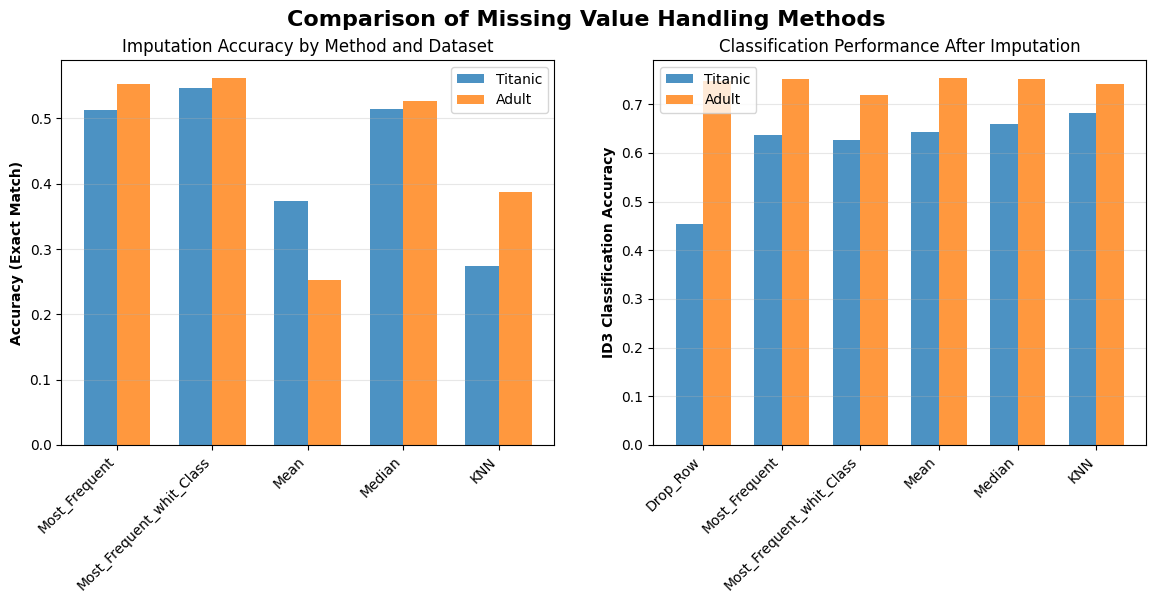

In [51]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Comparison of Missing Value Handling Methods',
             fontsize=16, fontweight='bold')

# Plot 1
methods = list(result_summary_t.keys())
acc_titanic = [result_summary_t[m]['accuracy'] for m in methods if m != 'Drop_Row']
acc_adult = [result_summary_a[m]['accuracy'] for m in methods if m != 'Drop_Row']
methods_plot = [m for m in methods if m != 'Drop_Row']

x = np.arange(len(methods_plot))
width = 0.35

axes[0].bar(x - width/2, acc_titanic, width, label='Titanic', alpha=0.8)
axes[0].bar(x + width/2, acc_adult, width, label='Adult', alpha=0.8)
axes[0].set_ylabel('Accuracy', fontweight='bold')
axes[0].set_title('Imputation Accuracy by Method and Dataset')
axes[0].set_xticks(x)
axes[0].set_xticklabels(methods_plot, rotation=45, ha='right')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Plot 2
class_acc_titanic = [metrics_titanic[m]['id3_accuracy'] for m in methods]
class_acc_adult = [metrics_adults[m]['id3_accuracy'] for m in methods]

x = np.arange(len(methods))
axes[1].bar(x - width/2, class_acc_titanic, width, label='Titanic', alpha=0.8)
axes[1].bar(x + width/2, class_acc_adult, width, label='Adult', alpha=0.8)
axes[1].set_ylabel('ID3 Classification Accuracy', fontweight='bold')
axes[1].set_title('Classification Performance After Imputation')
axes[1].set_xticks(x)
axes[1].set_xticklabels(methods, rotation=45, ha='right')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)



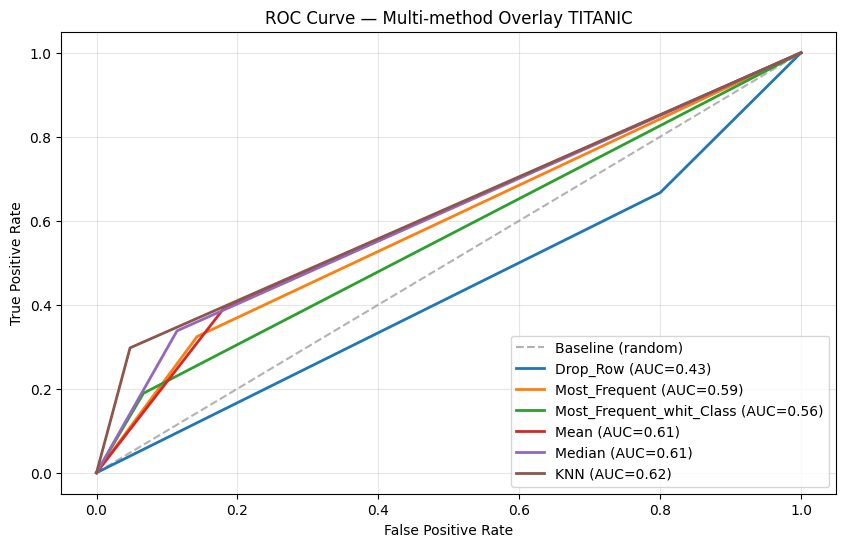

In [52]:

splits = splits_titanic
models = models_titanic

methods = list(splits.keys())

plt.figure(figsize=(10, 6))
# base random classifier
plt.plot([0, 1], [0, 1], '--', color='gray', alpha=0.6, label='Baseline (random)')

for name in methods:
    X_test = splits[name]["X_test"]
    y_test = splits[name]["y_test"]
    model  = models[name]

    # continues score
    try:
        y_scores = model.predict_proba(X_test)[:, 1]
    except Exception:

        y_scores = np.asarray(splits[name]["y_pred"]).astype(float)
    # safety check
    if len(y_scores) != len(y_test):
        raise ValueError(f"Length mismatch for '{name}': scores={len(y_scores)} vs y_test={len(y_test)}")
    # compute roc curve
    fpr, tpr, _ = roc_curve(y_test, y_scores)
    auc = roc_auc_score(y_test, y_scores)
    plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC={auc:.2f})")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Titanic")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()


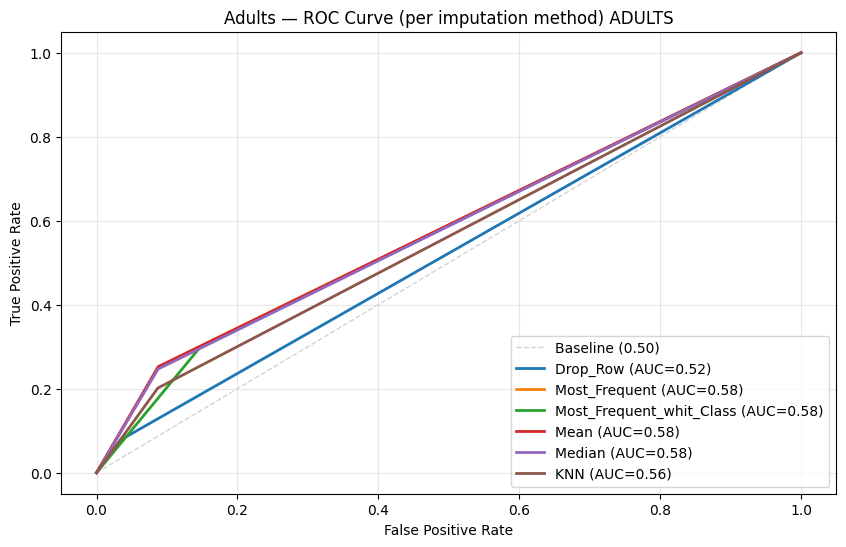

In [30]:
plt.figure(figsize=(10, 6))
plt.plot([0, 1], [0, 1], '--', color='lightgray', lw=1, label='Baseline (0.50)')

for name in list(splits_adults.keys()):
    X_te = splits_adults[name]["X_test"]
    y_te = splits_adults[name]["y_test"]
    model = models_adults[name]

    if len(np.unique(y_te)) < 2:
        continue

    try:
        y_scores = model.predict_proba(X_te)[:, 1]
    except Exception:
        y_scores = np.asarray(splits_adults[name]["y_pred"], dtype=float)


    if len(y_scores) != len(y_te):
        continue

    fpr, tpr, _ = roc_curve(y_te, y_scores)
    auc = roc_auc_score(y_te, y_scores)
    plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC={auc:.2f})")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Adults Income")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

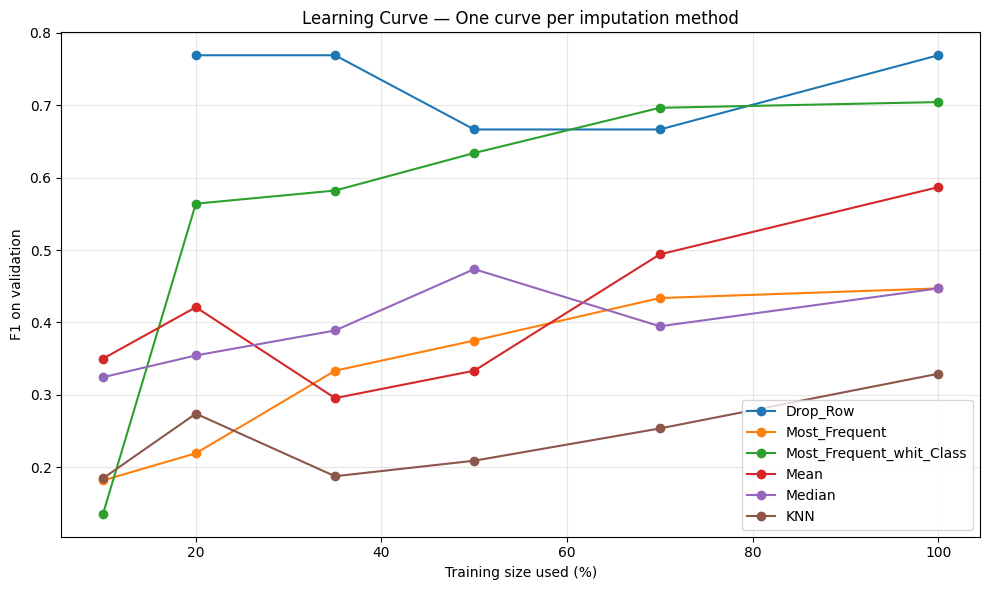

In [53]:
splits = splits_titanic
# uncomment for see in adults dataset (very slow)
# splits = splits_adults

methods = list(splits.keys())

# Learning-curve grid
train_fracs = np.array([0.10, 0.20, 0.35, 0.50, 0.70, 1.00])  # only this point for speed
val_size = 0.2
rng = np.random.RandomState(42)

plt.figure(figsize=(10, 6))

for name in methods:
    X_train_full = splits[name]["X_train"]
    y_train_full = splits[name]["y_train"]

    # split in train and test
    X_tr, X_val, y_tr, y_val = train_test_split(
        X_train_full, y_train_full,
        test_size=val_size, random_state=42, stratify=y_train_full
    )

    idx = rng.permutation(len(X_tr))
    X_tr_array = X_tr.iloc[idx].values
    y_tr_array = y_tr.iloc[idx].values
    X_val_array = X_val.values
    y_val_array = y_val.values

    # Keep column names for ID3
    col_names = X_tr.columns

    scores = []
    for frac in train_fracs:
        n_keep = max(2, int(frac * len(X_tr_array)))
        n_keep = min(n_keep, len(X_tr_array))

        X_small = pd.DataFrame(X_tr_array[:n_keep], columns=col_names)
        y_small = pd.Series(y_tr_array[:n_keep])

        if y_small.nunique() < 2:
            scores.append(np.nan)
            continue

        # Fit model
        model_tmp = fit_id3(X_small, y_small, max_depth=None)

        # Predict
        X_val_df = pd.DataFrame(X_val_array, columns=col_names)
        y_val_hat = predict_id3(model_tmp, X_val_df)

        f1 = f1_score(y_val_array, y_val_hat, zero_division=0)
        scores.append(f1)

    # Plot
    plt.plot(train_fracs * 100, scores, marker='o', label=name)

plt.xlabel("Training size used (%)")
plt.ylabel("F1 on validation")
plt.title("Learning Curve")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


## Conclusion

In this activity i reserch how missing value and how we hadle with this missing value change the model quality.
Keeping the classifier fixed (ID3) and changing the NaNs handling methods on a small dataset (titanic) and in a large one (adults income).
On both dataset simple methods like most frequent or median perfoerm well on the imputation, and class aware most frequent was the best method for recostruction the dataset from missing values.
Classification not always follow imputation accuracy, on **titanic** KNN give the best ID3 accuracy while drop_row perfoem very bad due to the small size of the dataset, lefting only 47 rows.
On **adults income** the best ID3 results come from mean, most frequent and median, all this methods very close on accuracy. Drop_row method do acceptable accuracy thanks to the larger sample, and class aware and most frequent methods become the worst in this big size dataset.

Overall dataset size strongly influence which missing value handling strategy is safe and effective.



## Use of AI
I use AI as an helper for define better the idea of this activity, for find the dataset that can suit this and for some code snippets especially for the plotting section.

## Future Work
Future work for this activity could involve trying other handling method for missing values like the Fractional Examples Approach seen in class and test on other models like Random Forest.